#  Handwritten Digit recognition

### Importing Libraries 

In [1]:
# Import necessary librariesr for data preprocessing and exploration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
# Importing ImageDataGenerator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Importing train_test_split for splitting the data into training and validation sets
from sklearn.model_selection import train_test_split
# Importing train_test_split for splitting the data into training and validation sets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Reading and Exploring the Data

In [2]:
# Load the data
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
x_train = train.drop(labels = ["label"],axis = 1) 
y_train = train["label"]

In [4]:
#number of classes
print('Number of classes=',y_train.nunique())
#names of classes
class_names=np.unique(y_train)
print('Classes we have:- ', class_names)
#number of samples in each class
y_train.value_counts()

Number of classes= 10
Classes we have:-  [0 1 2 3 4 5 6 7 8 9]


label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

Text(0.5, 1.0, 'Class Distribution')

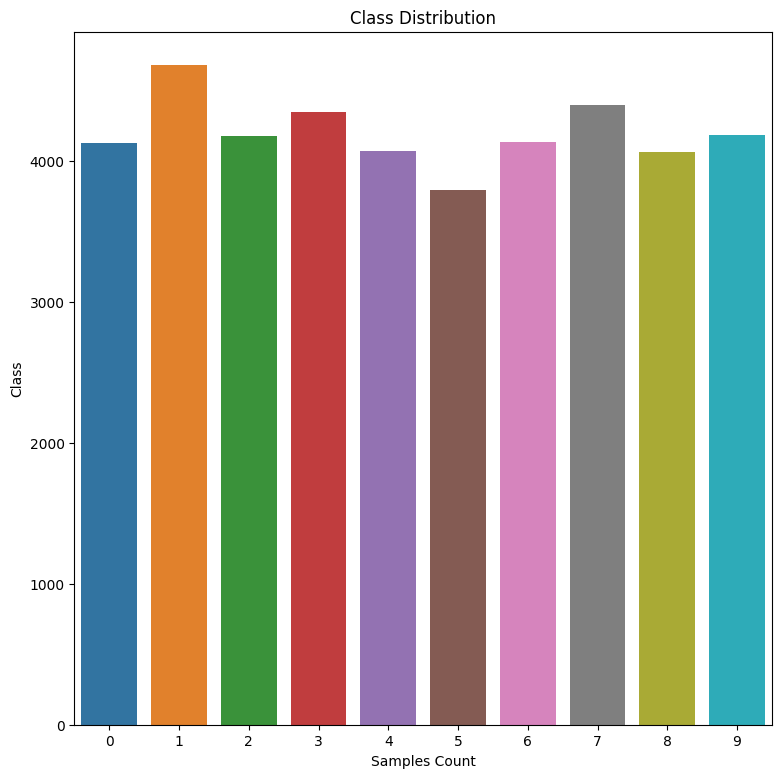

In [5]:
#this fig shows the distibution of classes
fig=plt.figure(figsize=(9,9))
sns.countplot(x=y_train,data=x_train)
plt.xlabel('Samples Count')
plt.ylabel('Class')
plt.title('Class Distribution')

In [6]:
# Normalize the data as cnn works better with [0,1] 
x_train = x_train / 255.0
test = test / 255.0
# Reshape image in 3 dimensions and let it be grayscale 
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [7]:
#convert labels using one_hot encoder
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y_train = to_categorical(y_train, num_classes = 10)

In [8]:
# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

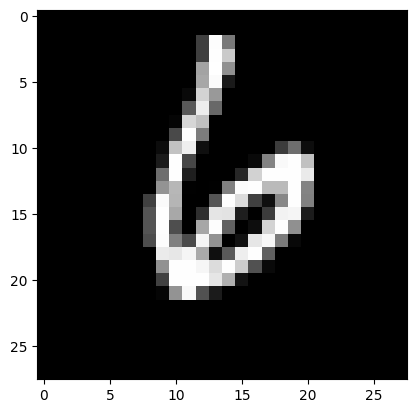

In [9]:
#show a sample from the data
plt.imshow(x_train[0].squeeze(), cmap='gray')
plt.show()

### Model architecture and training

In [10]:
# Define the model architecture
model = Sequential() # creates a new sequential model object

# first conovolutional layer
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(28, 28, 1))) # add a 2D conovolutional layer
model.add(MaxPooling2D(pool_size =(2,2)))   # add a 2d max pool of size 2x2
model.add(Dropout(0.25))    # drop out ayer that drops randomly 25% of units in pre layer to avoid overfitting

# second conovlutional layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size =(2,2)))
model.add(Dropout(0.25))


model.add(Flatten()) # flatten the layer to 1D array
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(10, activation = ('softmax'))) #we used softmax function because it's multi classification

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

In [11]:
# Define callbacks for early stopping and learning rate reduction
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=3)  # stop if validation loss doesn't improve for 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [12]:
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
#define the image generator for performing data augmentation on data during training
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [14]:
# Train the model
history = model.fit(x_train,y_train,epochs=10, validation_data=(x_val,y_val), batch_size=40, callbacks=callbacks)

Epoch 1/10
840/840 [==============================] - 22s 25ms/step - loss: 0.2970 - accuracy: 0.9043 - val_loss: 0.0758 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 2/10
840/840 [==============================] - 21s 24ms/step - loss: 0.0991 - accuracy: 0.9694 - val_loss: 0.0628 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 3/10
840/840 [==============================] - 20s 24ms/step - loss: 0.0792 - accuracy: 0.9757 - val_loss: 0.0414 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 4/10
840/840 [==============================] - 21s 24ms/step - loss: 0.0628 - accuracy: 0.9815 - val_loss: 0.0400 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 5/10
840/840 [==============================] - 20s 24ms/step - loss: 0.0560 - accuracy: 0.9818 - val_loss: 0.0347 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 6/10
840/840 [==============================] - 20s 24ms/step - loss: 0.0491 - accuracy: 0.9843 - val_loss: 0.0308 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 7/10
840/840 [==============================] - 20s 

### Model evaluation

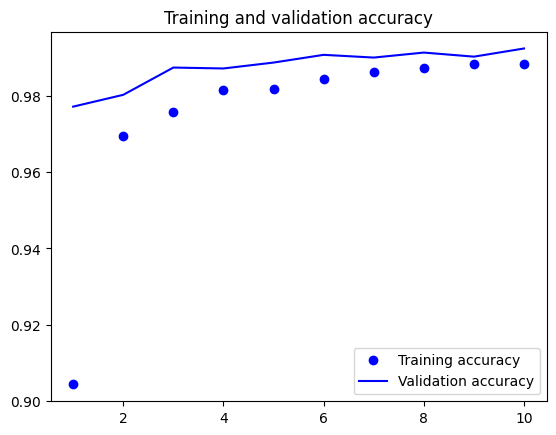

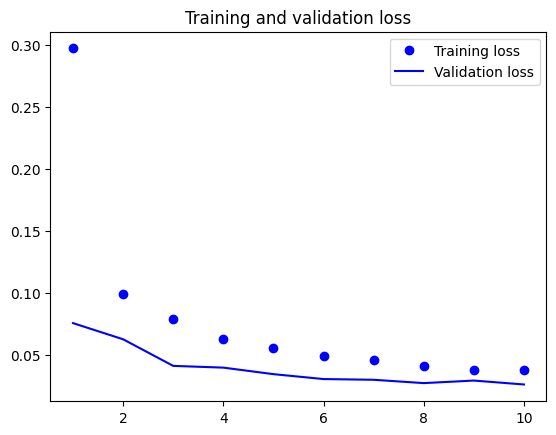

In [15]:
# Plot the accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
#final scores
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Training Loss: 0.0380
Final Validation Loss: 0.0264
Final Training Accuracy: 0.9883
Final Validation Accuracy: 0.9924


In [17]:
# Make predictions on the test data
predictions = model.predict(test)
# Get the predicted labels (class indices) for each sample
predicted_labels = predictions.argmax(axis=1)
# Print the predicted labels
print(predicted_labels)

875/875 [==============================] - 5s 5ms/step
[2 0 9 ... 3 9 2]


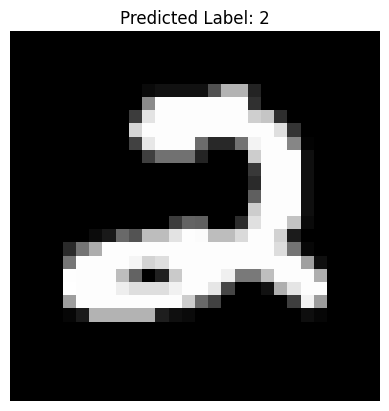

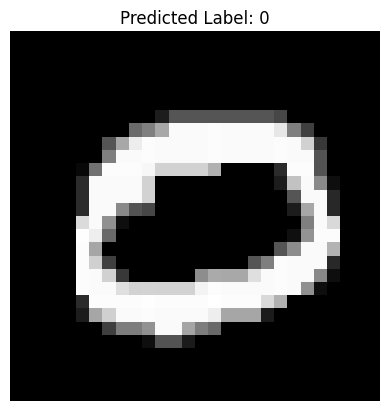

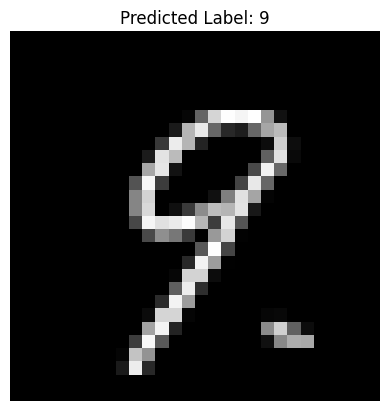

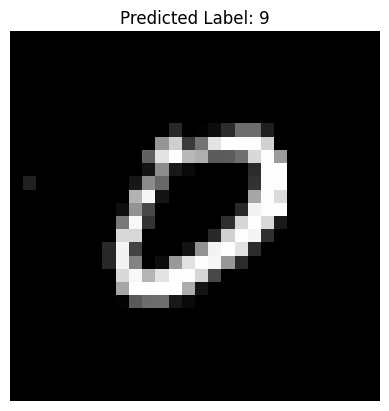

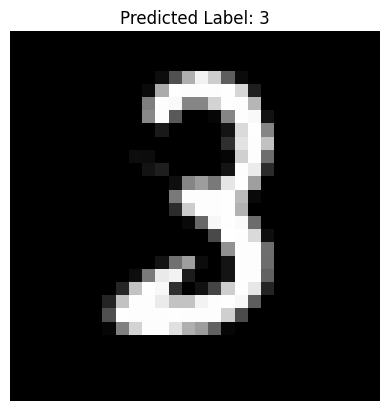

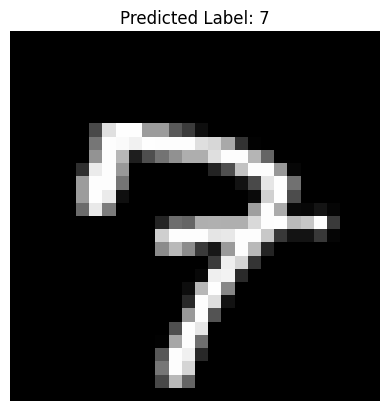

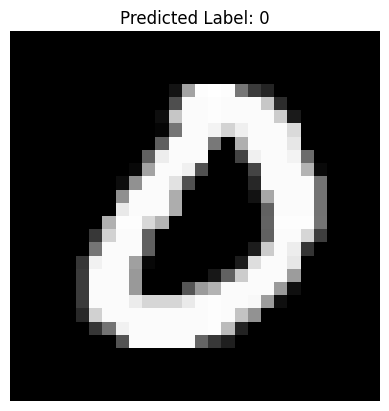

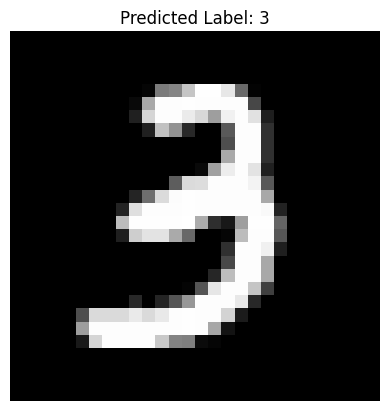

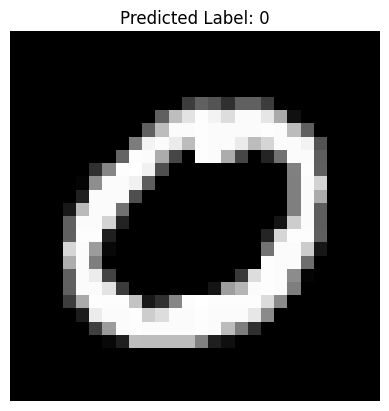

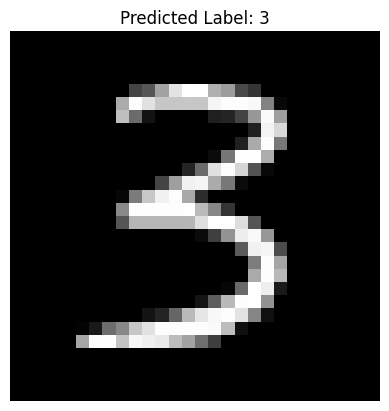

In [18]:
#define a function to show images and its predicted output
def plot_image(image, predicted_label):
    # Reshape the image from a flattened array to its original shape
    image = image.reshape((28, 28))
    
    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Set the title as the predicted label
    plt.title(f"Predicted Label: {predicted_label}")
    
    # Show the plot
    plt.show()

# Define the number of images to plot
num_images_to_plot = 10

# Iterate over the test data and plot the images with their predicted labels
counter = 0
for i in range(len(test)):
    if counter >= num_images_to_plot:
        break
    
    image = test[i]  # Get the image data
    predicted_label = predicted_labels[i]  # Get the predicted label
    
    # Plot the image and predicted label
    plot_image(image, predicted_label)
    
    counter += 1